In [1]:
# !pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy.signal import spectrogram as scipy_spectrogram
from collections import OrderedDict
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from obspy import read

In [4]:
root_dir  = '/content/drive/MyDrive/NASA_SpaceApps/space_apps_2024_seismic_detection'

In [5]:
model_dir = f'{root_dir}/models'
plots_dir = f'{root_dir}/plots'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [6]:
data_dir = f'{root_dir}/data/lunar'

In [7]:
cat_directory = f'{data_dir}/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [8]:
def load_seismic_data(mseed_directory, catalog):
    """
    Loads seismic signals from .mseed files and creates a dictionary mapping file names to signals.
    Also loads the P-wave start times from the catalog file and associates them with the signals.

    :param mseed_directory: Directory containing the .mseed files.
    :param catalog_file: CSV file containing catalog with P-wave start times.
    :return: A dictionary mapping filename to (signal, p_wave_start_time).
    """
    # Load the catalog CSV


    # Dictionary to hold file name : (signal, p_wave_start_time) mapping
    signal_mapping = OrderedDict()

    # Iterate through the rows in the catalog to match filenames and start times
    for index, row in catalog.iterrows():
        filename = row['filename'] + '.mseed'  # Assuming 'filename' is a column in your CSV
        p_wave_start_time = row['time_rel(sec)']  # Assuming 'p_wave_start_time' is in seconds

        # Full path to the .mseed file
        filepath = os.path.join(mseed_directory, filename)
        #print(filepath)
        if os.path.exists(filepath):
            # Load the .mseed file using obspy
            st = read(filepath)
            signal = st.traces[0].data  # Assuming we're only interested in the first trace

            # Store the signal and the associated P-wave start time in the dictionary
            signal_mapping[filename] = (signal, p_wave_start_time, st.traces[0].stats.sampling_rate)
        else:
            print(f"File {filename} not found in directory.")

    return signal_mapping

In [9]:
import cv2  # OpenCV for resizing
import numpy as np
from scipy.signal import spectrogram

def generate_spectrogram(signal, fs, window_size=5, overlap=0.8, target_size=(224, 224)):
    """
    Generate a spectrogram from the signal and resize it to a target size.

    :param signal: The 1D seismic signal.
    :param fs: Sampling frequency of the signal.
    :param window_size: Window size for the spectrogram.
    :param overlap: Overlap ratio for the spectrogram windows.
    :param target_size: The desired size for the output spectrogram (width, height).
    :return: Resized spectrogram of shape (target_size).
    """
    f, t, Sxx = spectrogram(signal, fs, nperseg=int(fs * window_size), noverlap=int(fs * overlap))
    Sxx = np.log1p(Sxx)  # Log scaling for better visualization

    # Resize the spectrogram to (224, 224)
    Sxx_resized = cv2.resize(Sxx, target_size, interpolation=cv2.INTER_AREA)

    return f, t, Sxx_resized


In [10]:
mseed_directory = f'{data_dir}/training/data/S12_GradeA'
signal_mapping = load_seismic_data(mseed_directory, cat)

File xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed not found in directory.


In [44]:
import cv2  # OpenCV for resizing
import numpy as np
from scipy.signal import spectrogram

# Simplified spectrogram generation function
def generate_spectrogram(signal, fs, window_size=5, overlap=0.8, target_size=(224, 224)):
    """
    Generate a spectrogram and resize it.

    :param signal: 1D array of the seismic signal.
    :param fs: Sampling frequency.
    :param window_size: Window size for the spectrogram.
    :param overlap: Overlap ratio for the spectrogram windows.
    :param target_size: The size to resize the spectrogram to.
    :return: Frequency array, time array, resized spectrogram, original spectrogram.
    """
    f, t, Sxx = spectrogram(signal, fs, nperseg=int(fs * window_size), noverlap=int(fs * overlap))
    Sxx = np.log1p(Sxx)  # Log scaling for visualization

    # Resize the spectrogram to (224, 224)
    Sxx_resized = cv2.resize(Sxx, target_size, interpolation=cv2.INTER_AREA)

    return f, t, Sxx_resized, Sxx

# Function to map P-wave start time to original spectrogram pixel
def map_time_to_pixel(p_wave_start_time, t):
    """
    Map P-wave start time (in seconds) to a pixel in the original spectrogram.

    :param p_wave_start_time: The P-wave start time in seconds.
    :param t: Time axis of the original spectrogram.
    :return: The pixel index corresponding to the P-wave start time.
    """
    time_index = np.argmin(np.abs(t - p_wave_start_time))
    return time_index

# Function to reverse map from resized pixel back to original time
def map_pixel_to_time(pred_pixel, original_t, target_size=224):
    """
    Map a pixel from resized spectrogram back to the original time axis.

    :param pred_pixel: Pixel index in the resized spectrogram.
    :param original_t: Time axis of the original spectrogram.
    :param target_size: Size of the resized spectrogram.
    :return: The corresponding time in seconds in the original time axis.
    """
    original_size = len(original_t)
    scale_factor = original_size / target_size  # Scale from resized back to original
    original_pixel = int(pred_pixel * scale_factor)

    # Ensure the pixel is within bounds
    if original_pixel >= original_size:
        original_pixel = original_size - 1

    return original_t[original_pixel]

# Generate X, y, and t_list for model training
def generate_X_y_time(signal_mapping, target_size=(224, 224)):
    X, y, t_list = [], [], []
    for filename, (signal, p_wave_start_time, fs) in signal_mapping.items():
        original_f, original_t, Sxx_resized, original_Sxx = generate_spectrogram(signal, fs, target_size=target_size)
        original_p_wave_pixel = map_time_to_pixel(p_wave_start_time, original_t)
        scale_factor = target_size[0] / len(original_t)
        resized_p_wave_pixel = int(original_p_wave_pixel * scale_factor)
        X.append(Sxx_resized)
        y.append(resized_p_wave_pixel)
        t_list.append(original_t)
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)  # Adding channel dimension for CNN input
    y = np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}, Time list length: {len(t_list)}")
    return X, y, t_list

# Split the data including time list
def split_data(X, y, t_list, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    t_train, t_test = train_test_split(t_list, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test, t_train, t_test

# Write report comparing predicted vs actual timestamps
def write_report(y_test, y_pred, t_test, filename=f"{root_dir}/results/p_wave_report.txt"):
    with open(filename, "w") as f:
        for i, (y_true, y_pred_pixel, t) in enumerate(zip(y_test, y_pred, t_test)):
            actual_time = map_pixel_to_time(y_true, t, target_size=224)
            predicted_time = map_pixel_to_time(y_pred_pixel, t, target_size=224)
            f.write(f"Sample {i}: Actual time: {actual_time:.2f}s, Predicted time: {predicted_time:.2f}s\n")
    print(f"Report saved to {filename}")

X, y, t_list = generate_X_y_time(signal_mapping)

# Split the data
X_train, X_test, y_train, y_test, t_train, t_test = split_data(X, y, t_list)

X shape: (75, 224, 224, 1), y shape: (75,), Time list length: 75


In [24]:
from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets
# def split_data(X, y, test_size=0.2, random_state=42):
#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#     print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")
#     return X_train, X_test, y_train, y_test

# # Split data for training and testing
# X_train, X_test, y_train, y_test = split_data(X, y)


Training data shape: (60, 224, 224, 1), Testing data shape: (15, 224, 224, 1)


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_cnn_model(input_shape=(224, 224, 1)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))

    # Output layer with one neuron (regression task: predict the pixel index)
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',  # Regression task
                  metrics=['mae'])  # Mean absolute error as a metric

    return model

# Create the CNN model
model = create_cnn_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
# Save the trained model
model.save(f'{root_dir}/models/p_wave_cnn_model.h5')


In [51]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,505,541 (127.81 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,337,028 (85.21 MB)

In [46]:
# Hyperparameters
batch_size = 32
epochs = 50
initial_lr = 0.001

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr])


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 17450.0020 - mae: 113.7003 - val_loss: 13689.8936 - val_mae: 102.4215 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 15307.1963 - mae: 103.6314 - val_loss: 12930.2920 - val_mae: 98.6436 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 16355.0303 - mae: 107.5698 - val_loss: 10821.6230 - val_mae: 88.6892 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 13238.8096 - mae: 94.1585 - val_loss: 6947.0747 - val_mae: 70.5960 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 8302.4512 - mae: 73.6861 - val_loss: 3258.9282 - val_mae: 48.3796 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 4784.7939 - mae: 60.5080 - val_loss: 6938.7344 - val_mae: 68.1551 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 6994.7178 - mae: 66.5402 - val_loss: 5432.2871 - va

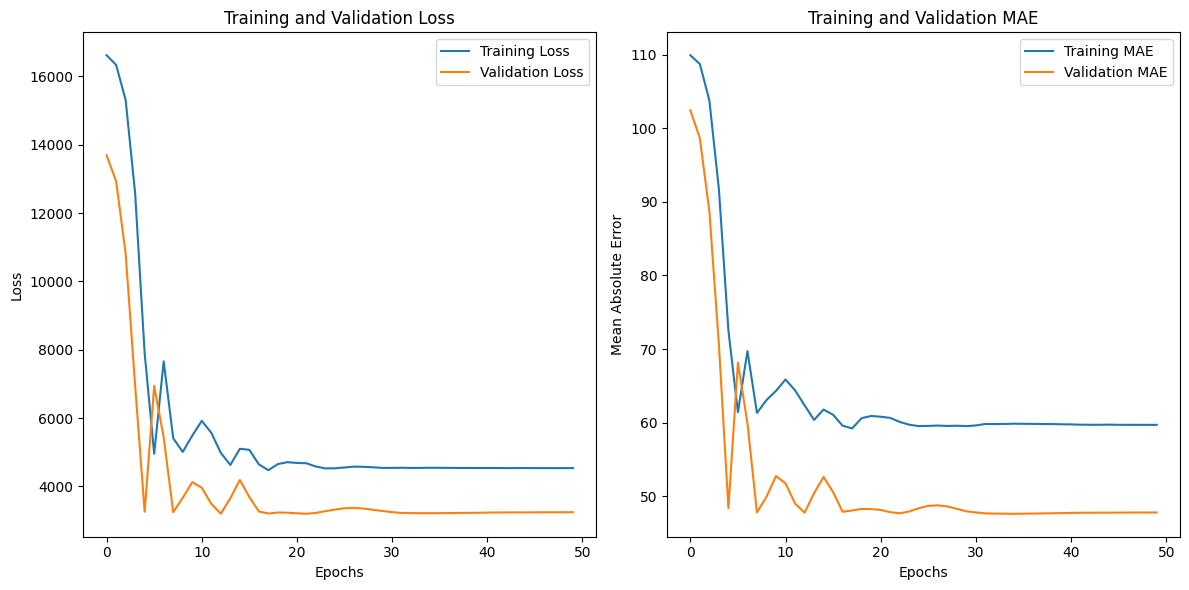

In [47]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Mean Absolute Error (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [48]:
X_train, X_test, y_train, y_test, t_train, t_test = split_data(X, y, t_list)

# Assuming you have a trained model
y_pred = model.predict(X_test)  # Uncomment this when you have the trained model

# Mock y_pred for testing
#y_pred = np.copy(y_test)  #
write_report(y_test, y_pred, t_test)

def plot_predicted_vs_expected(X_test, y_test, y_pred, t_test, output_dir="plots"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index in range(len(X_test)):
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(np.arange(224), np.linspace(0, 100, 224), X_test[index].squeeze(), shading='gouraud')
        plt.axvline(y_test[index], color='r', linestyle='--', label=f'Expected P-wave pixel: {int(y_test[index])}')
        plt.axvline(y_pred[index], color='g', linestyle='--', label=f'Predicted P-wave pixel: {int(y_pred[index])}')
        plt.colorbar(label='Log scaled amplitude')
        plt.xlabel('Time (pixels)')
        plt.ylabel('Frequency (Hz)')
        plt.legend()
        plt.title(f'Sample {index}: Predicted vs Expected P-wave Pixel')
        plt.savefig(os.path.join(output_dir, f"{root_dir}/results/sample{index}.png"))
        plt.close()

# Plot and save predicted vs expected results for each sample in the test set
plot_predicted_vs_expected(X_test, y_test, y_pred, t_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Report saved to /content/drive/MyDrive/NASA_SpaceApps/space_apps_2024_seismic_detection/results/p_wave_report.txt


<ipython-input-44-59793ade6a92>:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  original_pixel = int(pred_pixel * scale_factor)
<ipython-input-48-58e6003b0055>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.axvline(y_pred[index], color='g', linestyle='--', label=f'Predicted P-wave pixel: {int(y_pred[index])}')


In [49]:
print(y_test, y_pred)

[135  86 107 190  73  80 169  68 112 133 151   6  15  34 186] [[109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]
 [109.84294]]
